In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta
import statistics as stats 

import matplotlib.pyplot as plot
import matplotlib.ticker as mtick
import networkx as nx
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
#from gurobipy import GRB

In [2]:
#id directories
results_dir = os.getcwd()+'/outputs/updated_demand_oct25'

#change from scientific to float
pd.set_option('display.float_format', lambda x: '%0.2f' % x)

In [3]:
#various budgets tested in beggining of time period
budget_levels = list(range(6000000, 8000001, 1000000))
reliability_levels = [1]

#to easily test various warehouse capacities if needed for example case
warehouse_cap_level = 2

#define sets
T_set = 12
K_set = 3
I_set = 4

I_k_dict = {1: [1,2,3],
            2: [1,2,3,4],
            3: [1,2,3,4]}

#labels for graphs
names_SKU = ['Supplier A - N95(MG), i = 1', 
             'Supplier B - N95(MG), i = 2', 
             'Supplier A - SUR(MG), i = 3', 
             'Supplier C - KN95(NonMG), i = 4']
#names_commodity_type = ['Masks for Heath Care', 
#                        'Masks for Essential Businesses', 'Masks for Non-Essential Businesses']
names_commodity_type = ['Heath Providers - Masks, k = 1', 
                        'Essential Businesses - Masks, k = 2', 
                        'Nonessential Businesses - Masks, k = 3']
reliability_level_names = ['EXPECTED demand projections', 'HIGH demand projections']

In [4]:
#relevant factors for ordering plans 
#####SELECTED BUDGET###
selected_budget_level = 2

#relevant factors for 
####NUMBER OF ORDERING PERIODS PAST BEFORE UNEXPECTED EVENT###
past_before_unexpected_event = 1

In [5]:
def initialize_model(reliability_level, 
                     budget_level):
    
    model = ConcreteModel()
    
    #define sets
    T_set = 12
    K_set = 3
    I_set = 4

    I_k_dict = {1: [1,2,3],
               2: [1,2,3,4],
               3: [1,2,3,4]}

    #####initialize sets#######
    model.K = Set(initialize = range(1,K_set+1))
    model.I = Set(initialize = range(1,I_set+1))
    model.T = Set(initialize = range(1,T_set+1)) #change to time until event has past
    model.T_0 = Set(initialize = range(0,T_set+1)) #to calculate lead time distributions
    model.I_k = Set(model.K)
    for k in model.K:
        for i in range(0,len(I_k_dict[k])):
            model.I_k[k].add(I_k_dict[k][i])
    
    
    ####Healthcare commodity metric parameters
    r_k_dict = {
        1: 1.0,
        2: 0.4,
        3: 0.2
    }

    #suitability score (only specified for suitable items)
    q_k_i_dict = {
        tuple([1,1]):1,
        tuple([1,2]):1,
        tuple([1,3]):.9,
        tuple([1,4]):0,
        tuple([2,1]):1,
        tuple([2,2]):1,
        tuple([2,3]):.9,
        tuple([2,4]):.4,
        tuple([3,1]):1,
        tuple([3,2]):1,
        tuple([3,3]):.9,
        tuple([3,4]):.4
    }

    def rank_score_initialize(model, k):
        return(r_k_dict.get(k))

    model.r_k = Param(model.K, initialize = rank_score_initialize, 
                      within=Any)

    def suitability_score_initialize(model, k, i):
        if (i in model.I_k[k]):
            return(q_k_i_dict.get(tuple([k,i])))
        else:
            return(None)

    model.q_k_i = Param(model.K, model.I, initialize = suitability_score_initialize, 
                        within=Any)
    
    def healthcare_commodity_metric_initialize(model, k, i, t):
        if (i in model.I_k[k]):
            suitability_score = q_k_i_dict.get(tuple([k,i]))
            criticality_score = r_k_dict.get(k)
            phi_k_i_t_temp = suitability_score*(criticality_score*((1+criticality_score)**(T_set-t)))

            return(phi_k_i_t_temp)
        
        else:
            return(None)
        
    model.phi_k_i_t = Param(model.K, model.I, model.T, 
                            initialize = healthcare_commodity_metric_initialize, within=Any)
    

    #######warehouse capacity parameters#######

    #size
    s_i_dict = {
        1: 1,
        2: 1,
        3: 1,
        4: 1
    }

    def item_size_param_initialize(model, i):
        return(s_i_dict.get(i))

    model.s_i = Param(model.I, initialize = item_size_param_initialize)
    
    #total warehouse capacity
    h = 50000*warehouse_cap_level

    model.h = Param(initialize = h)

    #######budget and cost parameters########

    #price per unit
    c_i_dict = {
        1: 20,
        2: 60,
        3: 20,
        4: 5
    }

    #budget
    b = budget_level

    def cost_param_initialize(model, i):
        return(c_i_dict.get(i))

    model.c_i = Param(model.I, initialize = cost_param_initialize)

    def budget_param_initialize(model):
        return(b)

    model.b = Param(initialize = budget_param_initialize)

    ########inventory availability parameters##########
    #starting inventory
    z_i_init_dict = {
        1 : 0,
        2 : 0,
        3 : 4500,
        4 : 40000
    }

    def beg_inv_param_initialize(model, i):
        return(z_i_init_dict.get(i))

    model.z_i_init = Param(model.I, initialize = beg_inv_param_initialize)
    
    #incoming orders
    o_i_t_init_dict = {tuple([1,1]): 8000,
                      tuple([2,3]): 4666.67,
                       tuple([2,4]): 4666.67,
                       tuple([2,5]): 4666.67,
                       tuple([3,2]): 25000,
                      }
                
    def incoming_orders_initialize(model, i, t):
        if tuple([i,t]) in o_i_t_init_dict:
            return(o_i_t_init_dict.get(tuple([i,t])))
        else:
            return(0)

    model.o_i_t_init = Param(model.I, model.T, initialize = incoming_orders_initialize)

    #######Supply parameters########
    #lead times
    f_i_l_dict = {tuple([1, 1]): .5,
                 tuple([1, 2]): .5,
                 tuple([2, 2]): (1/3),
                 tuple([2, 3]): (1/3),
                 tuple([2, 4]): (1/3),
                 tuple([3, 1]): .5,
                 tuple([3, 2]): .5,
                 tuple([4, 0]): 1}
    
    def delay_dist_param_initialize(model, i, l):
        if tuple([i,l]) in f_i_l_dict:
            return(f_i_l_dict.get(tuple([i,l])))
        else:
            return(0)

    model.f_i_l = Param(model.I, model.T_0, 
                              initialize = delay_dist_param_initialize)

    #supply capacities
    cap_dictionary_supplier_SKU = {1: np.repeat([8000], T_set), #min, max, likely, a,b,c
                         2: np.repeat([14000,18000], [2,T_set-2]), 
                         3: [25000]*T_set,
                         4: [40000]*T_set}

    cap_dictionary_supplier_SKU_t = {}

    for i in model.I:
        for t in model.T:
            cap_dictionary_supplier_SKU_t[tuple([i,t])] = cap_dictionary_supplier_SKU[i][t-1]

    def supplier_cap_param_initialize(model, i, t):
        return(cap_dictionary_supplier_SKU_t[i,t])

    model.cap_i_t = Param(model.I, model.T, initialize = supplier_cap_param_initialize)

    ######demand parameters#########

    #unfulfilled demand
    n_k_init_dict = {
        1 : 0,
        2 : 0,
        3 : 0
    }
    

    #projected base incoming demand
    base_demand_k = {1: [7000, 10000, 14000],
                    2: [16000, 16000, 16000],
                    3: [18000, 18000, 18000]}

    #used in this example to adjust demand RV over time
    dynamic_adj_dem_t = {1: [0.75, .9, 1.2, 1.6, 1.8, 2.1, 1.9, 1.7, 1.5, 1.2, 1, 0.9],
                        2: [1.1,1.1,1,1,.9,.9,.9,.9,.9,1,1.1,1.1],
                        3: [1.3, 1.3, 1.2, 1, 0.8, 0.7, 0.8, 0.8, 1, 1, 1.3, 1.4]}
    
    epsilon = reliability_level
    
    def demand_param_initialize(model,k, t):
        base_demand_k_temp = base_demand_k[k]
        adjust_demand_temp = dynamic_adj_dem_t[k][t-1]
        demand_projection_temp = base_demand_k_temp[epsilon]*adjust_demand_temp

        return(demand_projection_temp)
    
    model.d_k_t = Param(model.K, model.T, initialize = demand_param_initialize)

    def unfulfilled_demand_param_initialize(model, k):
        return(n_k_init_dict.get(k))

    model.n_k_init = Param(model.K, initialize = unfulfilled_demand_param_initialize)

    #model.n_k_intialize.pprint()

    ####initialize variables####
    model.x_i_t = Var(model.I, model.T, within = NonNegativeReals) #amount ordered
    model.y_i_t = Var(model.I, model.T, within = NonNegativeReals) #amount recieved
    model.z_i_t = Var(model.I, model.T, within = NonNegativeReals)
    model.n_k_t = Var(model.K, model.T, within = NonNegativeReals)
    model.m_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
    
    return(model)

In [6]:
def initialize_objective(model):
    model.Objective = Objective(expr = 
                            (sum(model.phi_k_i_t[k,i,t]*model.m_k_i_t[k,i,t] 
                                                      for k in model.K for t in model.T for i in model.I_k[k])),
                            sense = maximize)
    
    return(model)

In [7]:
def initialize_constraints(model):
    
    def initialize_already_placed_ordered_accounted_for_initialize(model, i):
        return(model.x_i_t[i, 1] == 0)
    model.initialize_already_placed_ordered_accounted_for= \
    Constraint(model.I, rule = initialize_already_placed_ordered_accounted_for_initialize)
    
    def initalize_unsatisfied_demand_constraint_initialize(model, k):
        return(model.n_k_t[k,past_before_unexpected_event+1] == model.n_k_init[k])

    model.initalize_unsatisfied_demand_constraint= \
    Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)

    def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
        if (t < 12):
            return(sum(model.m_k_i_t[k,i,t] for i in model.I_k[k]) + model.n_k_t[k,t+1] == \
                  model.n_k_t[k,t] + model.d_k_t[k,t])
        else:
            return(sum(model.m_k_i_t[k,i,t] for i in model.I_k[k]) <= model.n_k_t[k,t] + model.d_k_t[k,t])

    model.calculate_unsatisfied_demand_constraint = \
    Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)
    
    def supplier_constraint_initialize(model, i, t):
        return(model.x_i_t[i,t] <= model.cap_i_t[i,t])

    model.supplier_constraint = \
    Constraint(model.I, model.T, rule = supplier_constraint_initialize)

    def incoming_orders_constraint_initialize(model, i, t):
        return(model.y_i_t[i,t] == 
               sum(model.f_i_l[i, t-t_ordered_time]*model.x_i_t[i,t_ordered_time] 
                   for t_ordered_time in range(past_before_unexpected_event+1,t+1)) + model.o_i_t_init[i,t])

    model.incoming_ordered_constraint = Constraint(model.I, model.T, 
                                                   rule = incoming_orders_constraint_initialize)

    def beggining_inventory_constraint_initialize(model, i):
        return(model.z_i_t[i,past_before_unexpected_event+1] == model.z_i_init[i])

    model.beggining_inventory_constraint = Constraint(model.I, 
                                                      rule = beggining_inventory_constraint_initialize)

    def calculate_available_inventory_constraint_initialize(model, i, t):
        if (t > (past_before_unexpected_event+1)):
            return(model.z_i_t[i,t] == model.z_i_t[i,t-1] + model.y_i_t[i,t-1] - \
                   sum(model.m_k_i_t[k,i,t-1] for k in model.K))
        else:
            return(Constraint.Skip)

    model.calculate_available_inventory_constraint = Constraint(model.I, model.T,
                                                                rule = 
                                                                calculate_available_inventory_constraint_initialize)

    def cannot_fulfill_more_than_available_constraint_initialize(model, i, t):
        return(sum(model.m_k_i_t[k,i,t] for k in model.K) <= model.z_i_t[i,t])

    model.cannot_fulfill_more_than_available_constraint = \
    Constraint(model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)

    def warehouse_capacity_constraint_initialize(model, t):
        return(sum(model.s_i[i]*model.z_i_t[i,t] for i in model.I) <= model.h)

    model.warehouse_capacity_constraint = \
    Constraint(model.T, rule = warehouse_capacity_constraint_initialize)

    def budget_constraint_initialize(model):
        return(sum(model.c_i[i]*model.x_i_t[i,t] 
                   for i in model.I for t in model.T) 
               <= model.b)

    model.budget_constraint = \
    Constraint(rule = budget_constraint_initialize)
    
    return(model)

In [8]:
def extract_data(model, reliability_level, budget, 
                 unsatisfied_df, fulfilled_df, recieved_df, ordered_df, demand_df):
    
    #extract from unsatisfied_df
    def unsatisfied_df_update(unsatisfied_df):
        if unsatisfied_df.empty:
            unsatisfied_df = pd.DataFrame(list(model.n_k_t.extract_values().items()),\
                                          columns = ['sets','units_unsatisfied'])
            unsatisfied_df = unsatisfied_df[unsatisfied_df['units_unsatisfied'].notnull()]            
            unsatisfied_df.loc[:,'commodity_type']=unsatisfied_df.sets.map(lambda x:x[0])
            unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])
            unsatisfied_df = unsatisfied_df[['commodity_type', 'time_interval', 
                                             'units_unsatisfied']]
            unsatisfied_df ['reliability_level'] = [reliability_level]*len(unsatisfied_df)
            unsatisfied_df['budget'] = [budget]*len(unsatisfied_df)
            return(unsatisfied_df)
        else:
            unsatisfied_df_temp = pd.DataFrame(list(model.n_k_t.extract_values().items()),\
                                          columns = ['sets','units_unsatisfied'])
            unsatisfied_df_temp.loc[:,'commodity_type']=unsatisfied_df_temp.sets.map(lambda x:x[0])
            unsatisfied_df_temp.loc[:,'time_interval']=unsatisfied_df_temp.sets.map(lambda x:x[1])
            unsatisfied_df_temp = unsatisfied_df_temp[['commodity_type', 'time_interval', 
                                                       'units_unsatisfied']]
            unsatisfied_df_temp ['reliability_level'] = [reliability_level]*len(unsatisfied_df_temp)
            unsatisfied_df_temp['budget'] = [budget]*len(unsatisfied_df_temp)
            unsatisfied_df_temp = unsatisfied_df_temp[unsatisfied_df_temp['units_unsatisfied'].notnull()]

            return(unsatisfied_df.append(unsatisfied_df_temp, ignore_index=True))
        
    #extract from satisfied_df
    def fulfilled_df_update(fulfilled_df):
        if fulfilled_df.empty:
            fulfilled_df = pd.DataFrame(list(model.m_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
            fulfilled_df.loc[:,'commodity_type']=fulfilled_df.sets.map(lambda x:x[0])
            fulfilled_df.loc[:,'SKU']=fulfilled_df.sets.map(lambda x:x[1])
            fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])
            fulfilled_df['reliability_level'] = [reliability_level]*len(fulfilled_df)
            fulfilled_df['budget'] = [budget]*len(fulfilled_df)
            fulfilled_df = fulfilled_df[fulfilled_df['units_fulfilled'].notnull()]
            return(fulfilled_df)
        else:
            fulfilled_df_temp = pd.DataFrame(list(model.m_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
            fulfilled_df_temp.loc[:,'commodity_type']=fulfilled_df_temp.sets.map(lambda x:x[0])
            fulfilled_df_temp.loc[:,'SKU']=fulfilled_df_temp.sets.map(lambda x:x[1])
            fulfilled_df_temp.loc[:,'time_interval']=fulfilled_df_temp.sets.map(lambda x:x[2])
            fulfilled_df_temp['reliability_level'] = [reliability_level]*len(fulfilled_df_temp)
            fulfilled_df_temp['budget'] = [budget]*len(fulfilled_df_temp)
            fulfilled_df_temp = fulfilled_df_temp[fulfilled_df_temp['units_fulfilled'].notnull()]

            return(fulfilled_df.append(fulfilled_df_temp, ignore_index=True))
        
    def recieved_df_update(recieved_df):
        if recieved_df.empty:
            recieved_df = pd.DataFrame(list(model.y_i_t.extract_values().items()),columns = ['sets','units_recieved'])
            recieved_df.loc[:,'SKU']=recieved_df.sets.map(lambda x:x[0])
            recieved_df.loc[:,'time_interval']=recieved_df.sets.map(lambda x:x[1])
            recieved_df['reliability_level'] = [reliability_level]*len(recieved_df)
            recieved_df['budget'] = [budget]*len(recieved_df)
            
            return(recieved_df)
        else:
            recieved_df_temp = pd.DataFrame(list(model.y_i_t.extract_values().items()),columns = ['sets','units_recieved'])
            recieved_df_temp.loc[:,'SKU']=recieved_df_temp.sets.map(lambda x:x[0])
            recieved_df_temp.loc[:,'time_interval']=recieved_df_temp.sets.map(lambda x:x[1])
            recieved_df_temp['reliability_level'] = [reliability_level]*len(recieved_df_temp)
            recieved_df_temp['budget'] = [budget]*len(recieved_df_temp)
            
            return(recieved_df.append(recieved_df_temp, ignore_index = True))
    
    def ordered_df_update(ordered_df):
        if ordered_df.empty:
            ordered_df = pd.DataFrame(list(model.x_i_t.extract_values().items()),columns = ['sets','units_to_order'])
            ordered_df.loc[:,'SKU']=ordered_df.sets.map(lambda x:x[0])
            ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[1])
            ordered_df['reliability_level'] = [reliability_level]*len(ordered_df)
            ordered_df['budget'] = [budget]*len(ordered_df)
            
            return(ordered_df)
        else:
            ordered_df_temp = pd.DataFrame(list(model.x_i_t.extract_values().items()),columns = ['sets','units_to_order'])
            ordered_df_temp.loc[:,'SKU']=ordered_df_temp.sets.map(lambda x:x[0])
            ordered_df_temp.loc[:,'time_interval']=ordered_df_temp.sets.map(lambda x:x[1])
            ordered_df_temp['reliability_level'] = [reliability_level]*len(ordered_df_temp)
            ordered_df_temp['budget'] = [budget]*len(ordered_df_temp)
            
            return(ordered_df.append(ordered_df_temp, ignore_index = True))
    
    #extract from unsatisfied_df
    def demand_df_update(demand_df):
        if demand_df.empty:
            demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()),\
                                          columns = ['sets','incoming_demand'])
            demand_df = demand_df[demand_df['incoming_demand'].notnull()]            
            demand_df.loc[:,'commodity_type']=demand_df.sets.map(lambda x:x[0])
            demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])
            demand_df = demand_df[['commodity_type', 'time_interval', 
                                             'incoming_demand']]
            demand_df['reliability_level'] = [reliability_level]*len(demand_df)
            return(demand_df)
        else:
            demand_df_temp = pd.DataFrame(list(model.d_k_t.extract_values().items()),\
                                          columns = ['sets','incoming_demand'])
            demand_df_temp.loc[:,'commodity_type']=demand_df_temp.sets.map(lambda x:x[0])
            demand_df_temp.loc[:,'time_interval']=demand_df_temp.sets.map(lambda x:x[1])
            demand_df_temp = demand_df_temp[['commodity_type', 'time_interval', 
                                                       'incoming_demand']]
            demand_df_temp ['reliability_level'] = [reliability_level]*len(demand_df_temp)

            return(demand_df.append(demand_df_temp, ignore_index=True))
    
    unsatisfied_df = unsatisfied_df_update(unsatisfied_df)
    fulfilled_df = fulfilled_df_update(fulfilled_df)
    ordered_df = ordered_df_update(ordered_df)
    demand_df = demand_df_update(demand_df)
    recieved_df = recieved_df_update(recieved_df)
    
    return(unsatisfied_df, fulfilled_df, recieved_df, ordered_df, demand_df)

In [9]:
fulfilled_df_plan = pd.DataFrame()
unsatisfied_df_plan = pd.DataFrame()
ordered_df_plan = pd.DataFrame()
demand_df_plan = pd.DataFrame()
recieved_df_plan = pd.DataFrame()

for r in reliability_levels:
    for b in budget_levels:
        model = initialize_model(r, b)
        model = initialize_objective(model)
        model = initialize_constraints(model)
        opt = pyomo.opt.SolverFactory("glpk")
        results = opt.solve(model)
        opt.solve(model)

        unsatisfied_df_plan, fulfilled_df_plan, recieved_df_plan, ordered_df_plan, demand_df_plan = \
        extract_data(model, r, b, unsatisfied_df_plan, 
                     fulfilled_df_plan, recieved_df_plan, ordered_df_plan, demand_df_plan)
        
        
demand_df_plan = \
demand_df_plan.drop_duplicates(subset=['reliability_level',
                                       'commodity_type',
                                      'time_interval'])

In [10]:
#set current working directory to output file
os.chdir(results_dir)

In [11]:
#set up delay df to calculate average delay
#group filfilled and unsatisfied demand over item type (over all supplier-SKUs)
delay_ref_df = fulfilled_df_plan.groupby(['commodity_type', 'time_interval', 
                      'reliability_level', 'budget'])['units_fulfilled'].sum().reset_index()

#create a unique id to calculate cum fulfilled (for calculating delay) based on reliability level, budget and item type
delay_ref_df['unique_id'] = delay_ref_df\
.groupby(['reliability_level', 'budget', 'commodity_type']).ngroup()
delay_ref_df = delay_ref_df.sort_values(by=['unique_id', 'time_interval', 'commodity_type'])
delay_ref_df = delay_ref_df.reset_index(drop = True)

unique_id_itr = 0
cum_units_fulfilled_array = np.zeros(len(delay_ref_df))

for row in range(len(delay_ref_df)):
    units_fulfilled_temp = delay_ref_df['units_fulfilled'][row]
    
    if delay_ref_df['unique_id'][row] == unique_id_itr:
        cum_units_fulfilled_array[row] = units_fulfilled_temp+cum_units_fulfilled_array[row-1]
    else:
        cum_units_fulfilled_array[row] = units_fulfilled_temp 
        
    unique_id_itr = delay_ref_df['unique_id'][row]
    
delay_ref_df = pd.merge(delay_ref_df, demand_df_plan,
                    how = 'left', on = ['commodity_type','time_interval',
                                        'reliability_level'])

In [12]:
#create reference table for unique ID's
#that combine item type, budget, and reliability level
commodity_relibaility_ref_id_df = delay_ref_df.drop_duplicates(subset=['unique_id'])

commodity_relibaility_ref_id_df = commodity_relibaility_ref_id_df[['unique_id',
                                                                  'commodity_type',
                                                                  'reliability_level',
                                                                  'budget']]

In [13]:
#create a demand fulfillment schedule assuming FIFO
demand_fulfillment_schedule_df = pd.DataFrame(columns=['unique_id', 'time_interval', 
                                                      'units_fulfilled', 'incoming_demand'])

for newcol in range(1,T_set+1):
    demand_fulfillment_schedule_df[newcol] = ""
    
for unique_id_itr in delay_ref_df['unique_id'].unique():
    delay_ref_df_temp = delay_ref_df[delay_ref_df['unique_id'] == unique_id_itr]
    fulfilled_remaining = (delay_ref_df_temp['units_fulfilled']).to_numpy()
    incoming_demand_remaining = (delay_ref_df_temp['incoming_demand']).to_numpy()
    
    for t1 in range(1,T_set+1):
        demand_fulfillment_schedule_df = \
        demand_fulfillment_schedule_df.append({'unique_id': unique_id_itr,\
                                               'time_interval': t1,\
                                               'units_fulfilled': fulfilled_remaining[t1-1],
                                               'incoming_demand': incoming_demand_remaining[t1-1]},\
                                               #'remaining_demand': incoming_demand_remaining[t1-1],
                                               #'remaining_units_fulfilled': fulfilled_remaining[t1-1]},
                                              ignore_index=True)  
        
demand_fulfillment_schedule_df = demand_fulfillment_schedule_df.fillna(0)

for unique_id_itr in delay_ref_df['unique_id'].unique():
    delay_ref_df_temp = delay_ref_df[delay_ref_df['unique_id'] == unique_id_itr]
    fulfilled_orig_temp = (delay_ref_df_temp['units_fulfilled']).to_numpy()
    demand_orig_temp = (delay_ref_df_temp['incoming_demand']).to_numpy()
    
    time_requested = 1
    time_fulfilled = 1
    
    while time_requested <= T_set and time_fulfilled <= T_set:
        
        #calculate the amount of the fulfilled demand accounted for at time_fulfilled
        demand_fulfillment_schedule_df_temp = \
        demand_fulfillment_schedule_df[demand_fulfillment_schedule_df['unique_id']==unique_id_itr]
        amt_fulfilled_accounted_for = sum(demand_fulfillment_schedule_df_temp[time_fulfilled])
        
        fulfilled_remaining = fulfilled_orig_temp[time_fulfilled-1]-amt_fulfilled_accounted_for
        
        #calculate the amount of demand accounted for at time_requested
        demand_index = demand_fulfillment_schedule_df[(demand_fulfillment_schedule_df['time_interval'] == time_requested) &
                                      (demand_fulfillment_schedule_df['unique_id'] == unique_id_itr)].index[0]
        amt_demand_fulfilled = sum(demand_fulfillment_schedule_df.iloc[demand_index,-T_set:])
        
        demand_remaining = demand_orig_temp[time_requested-1]-amt_demand_fulfilled
        
        
        #the amount fulfilled at during time interval time_fulfilled, 
        #that was orig. requested at time time_requested is the min of fulfilled and demand remaining
        
        amt_fulfilled = min(fulfilled_remaining, demand_remaining)
        
        demand_fulfillment_schedule_df.loc[(demand_fulfillment_schedule_df['time_interval'] == time_requested) \
                                   & (demand_fulfillment_schedule_df['unique_id'] == unique_id_itr),\
                                   time_fulfilled] = amt_fulfilled
        
            
            
        #if there is no more remaining demand requests unassigned orig. requested at time time_requested
        #AND there is no more unassigned fulfilled demand from time time_fulfilled
        if (fulfilled_remaining == demand_remaining):
            time_requested = time_requested+1
            time_fulfilled = time_fulfilled+1
            
        #if there is remaining demand requests, but no more fulfilled demand
        if (fulfilled_remaining < demand_remaining):
            time_fulfilled = time_fulfilled+1
            
        #if there is remaining fulfilled demand, but no more demand requests
            
        if (fulfilled_remaining > demand_remaining):
            time_requested = time_requested+1
        
#units unfullfilled at time interval 13
demand_fulfillment_schedule_df[13] = \
demand_fulfillment_schedule_df['incoming_demand']-\
demand_fulfillment_schedule_df.loc[:,demand_fulfillment_schedule_df.\
                                   columns[-T_set:]].sum(1)

#if want to print and check demand fulfillment schedule
demand_fulfillment_schedule_df.to_csv('demand_fulfillment_schedule_df.csv', index=False)

In [14]:
#calculate percent delayed from delay fulfillment schedule
delay_calcs_df=pd.melt(demand_fulfillment_schedule_df, 
                       id_vars=['unique_id', 'time_interval',
                                'units_fulfilled', 'incoming_demand'])
delay_calcs_df = delay_calcs_df.rename(columns={"variable": "time_interval_fulfilled", 
                               "time_interval": "time_interval_requested"})

delay_calcs_df=delay_calcs_df[['unique_id', 'time_interval_fulfilled', 'time_interval_requested', 'value']]
delay_calcs_df = delay_calcs_df[delay_calcs_df['value']>0]
delay_calcs_df['delay'] = delay_calcs_df['time_interval_fulfilled']-delay_calcs_df['time_interval_requested']
delay_calcs_df.loc[delay_calcs_df['delay']>0, 'is_delayed'] = 1
delay_calcs_df.loc[delay_calcs_df['delay']==0, 'is_delayed'] = 0

delay_calcs_df['n_delay'] = delay_calcs_df['value']*delay_calcs_df['is_delayed']

delay_calcs_df_summarised = delay_calcs_df[['unique_id', 'value', 'n_delay']]\
.groupby(by = ['unique_id'])\
.sum().reset_index()
delay_calcs_df_summarised['perc_delayed'] = (delay_calcs_df_summarised['n_delay']/delay_calcs_df_summarised['value'])*100

#to account that we don't know if items will be delayed past week 13
#so for requests delayed at week 12 we dont know 
#if they are actually delayed more than 2 weeks
delay_calcs_df2=pd.melt(demand_fulfillment_schedule_df[demand_fulfillment_schedule_df['time_interval']<T_set], 
                       id_vars=['unique_id', 'time_interval',
                                'units_fulfilled', 'incoming_demand'])
delay_calcs_df2 = delay_calcs_df2.rename(columns={"variable": "time_interval_fulfilled", 
                               "time_interval": "time_interval_requested"})

delay_calcs_df2=delay_calcs_df2[['unique_id', 'time_interval_fulfilled', 'time_interval_requested', 'value']]
delay_calcs_df2 = delay_calcs_df2[delay_calcs_df2['value']>0]
delay_calcs_df2['delay'] = delay_calcs_df2['time_interval_fulfilled']-delay_calcs_df2['time_interval_requested']
delay_calcs_df2.loc[delay_calcs_df2['delay']>1, 'is_delayed_2'] = 1
delay_calcs_df2.loc[delay_calcs_df2['delay']<=1, 'is_delayed_2'] = 0

delay_calcs_df2['n_delay2'] = delay_calcs_df2['value']*delay_calcs_df2['is_delayed_2']

delay_calcs_df2_summarised = delay_calcs_df2[['unique_id', 'value', 'n_delay2']]\
.groupby(by = ['unique_id'])\
.sum().reset_index()
delay_calcs_df2_summarised['perc_delayed_2'] = (delay_calcs_df2_summarised['n_delay2']/delay_calcs_df2_summarised['value'])*100


#combine
delay_calcs_df_summarised = delay_calcs_df_summarised[['unique_id', 'perc_delayed']].\
merge(delay_calcs_df2_summarised[['unique_id', 'perc_delayed_2']], on = 'unique_id',
     how = 'left')

delay_calcs_df_summarised = delay_calcs_df_summarised.merge(commodity_relibaility_ref_id_df,
                                                           on = 'unique_id',
                                                           how = 'left')

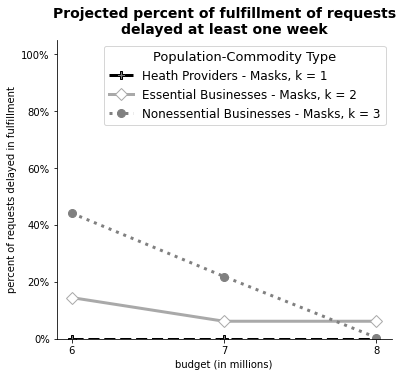

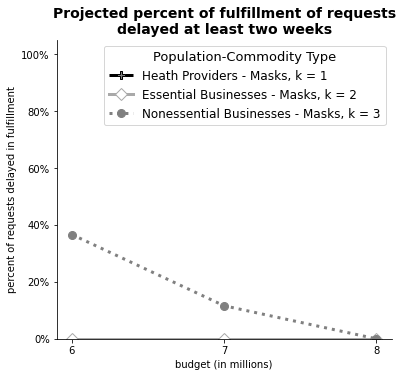

In [15]:
###create figures delays###
#seperate###
delay_calcs_df_summarised['budget_M'] = (delay_calcs_df_summarised['budget']/1000000)
line_style_lookup = ['--', '-', ':']
marker_style_lookup = ['P', 'D', 'o']
color_lookup = ['black', 'darkgrey', 'grey']
marker_color_lookup = ['white', 'white', 'grey']
title_delay = ['Projected percent of fulfillment of requests\ndelayed at least one week',
         'Projected percent of fulfillment of requests\ndelayed at least two weeks']

for rely in [1]:
    df1 = delay_calcs_df_summarised[delay_calcs_df_summarised['commodity_type'] == 1]
    df2 = delay_calcs_df_summarised[delay_calcs_df_summarised['commodity_type'] == 2]
    df3 = delay_calcs_df_summarised[delay_calcs_df_summarised['commodity_type'] == 3]
    y_axis_col_name = ['perc_delayed', 'perc_delayed_2']
    title_adj = ['Percent of requests delayed at least ONE time interval (week)',\
                 'Percent of requests delayed at least TWO time interval (week)']
    
    for n_delay in [0,1]:
        fig, ax = plot.subplots(1, 1, figsize=(6,5.5))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_xticks(np.arange(5,9,step = 1))
        ax.set(xlabel = 'budget (in millions)', \
                                 ylabel = 'percent of requests delayed in fulfillment')#title_adj[n_delay])
        ax.set(ylim=(0, 105))
        
        ax.plot('budget_M', y_axis_col_name[n_delay], 
                  data=df1[(df1['reliability_level'] == rely)],
                 marker = marker_style_lookup[0], color = color_lookup[0], markersize=8, 
                label = names_commodity_type[0], markerfacecolor = marker_color_lookup[2],
               linestyle = line_style_lookup[0], linewidth = 3)#3: ' + r'$r_k = 0.2$')
        ax.plot('budget_M', y_axis_col_name[n_delay], 
                data=df2[(df2['reliability_level'] == rely)],
                marker = marker_style_lookup[1], color = color_lookup[1], markersize=8, 
                label = names_commodity_type[1], markerfacecolor = marker_color_lookup[1],
               linestyle = line_style_lookup[1], linewidth = 3)
        ax.plot('budget_M', y_axis_col_name[n_delay], 
                  data=df3[(df3['reliability_level'] == rely)],
                 marker = marker_style_lookup[2], color = color_lookup[2], 
                markersize=8, label = names_commodity_type[2], markerfacecolor = marker_color_lookup[2],
               linestyle = line_style_lookup[2], linewidth = 3)#: ' + r'$r_k = 1.0$')
        
        #ax.set_title(title_adj[n_delay]+'\nby Population-Commodity Type')
        ax.legend([names_commodity_type[0], names_commodity_type[1], names_commodity_type[2]],
                  loc = 'upper right', title = 'Population-Commodity Type', ncol = 1,
                  facecolor='white', fontsize = 12, title_fontsize=13)
        
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top_side = ax.spines["top"]
        top_side.set_visible(False)
        plot.title(title_delay[n_delay], fontsize = 14, fontweight="bold")
        
        fig.savefig('delay_'+str(n_delay)+'.png', dpi=300, bbox_inches='tight')

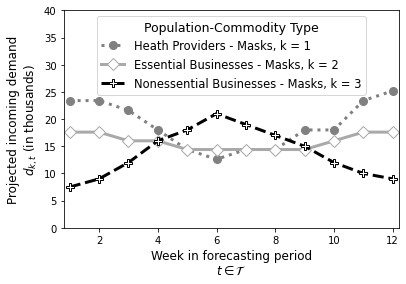

In [16]:
#illustrate demand projections
demand_df_r1 = demand_df_plan[demand_df_plan['reliability_level'] == 1]
line_style_lookup = ['--', '-', ':']
marker_style_lookup = ['P', 'D', 'o']
color_lookup = ['black', 'darkgrey', 'grey']
marker_color_lookup = ['white', 'white', 'grey']

for k in reversed(range(1, K_set+1)):
    temp = demand_df_r1[demand_df_r1['commodity_type'] == k]
    plot.plot(temp['time_interval'], temp['incoming_demand']/1000, 
              label = names_commodity_type[k-1],
              marker = marker_style_lookup[k-1],
              linestyle = line_style_lookup[k-1],
             linewidth = 3,
             markersize = 8,
             c = color_lookup[k-1],
             markerfacecolor = marker_color_lookup[k-1])
plot.xlim([.8,12.2])
plot.ylim([0, 40])
plot.legend([names_commodity_type[0], names_commodity_type[1], names_commodity_type[2]],
            title = 'Population-Commodity Type', fontsize = 11.5, 
            fancybox = True, title_fontsize=12.5, ncol = 1,
           loc = 'upper center')
plot.xlabel('Week in forecasting period\n'+r'$t\in\mathcal{T}$', fontsize = 12)
plot.ylabel('Projected incoming demand\n'+r'$d_{k,t}$'+' (in thousands)', fontsize =12)

plot.savefig('demand_projections.png')

In [17]:
####impact of budget on delays and suitability overtime ###
#reliability level 1
#commodity 1
#preprocessing
fulfilled_df_rely1 = fulfilled_df_plan[fulfilled_df_plan['reliability_level'] == 1]
unsatisfied_df_rely1 = unsatisfied_df_plan[unsatisfied_df_plan['reliability_level'] == 1]
pal = ['#1f77b4', '#ff7f0e', '#2ca02c', "808080"]
#the paper will only highlight health care overtime
k = 1
fulfilled_df_rely1_k1 = fulfilled_df_rely1[fulfilled_df_rely1['commodity_type'] == k]
fulfilled_df_rely1_k1['group'] = fulfilled_df_rely1_k1['SKU'].apply(lambda x: names_SKU[x-1])
fulfilled_df_rely1_k1 = fulfilled_df_rely1_k1[['time_interval', 'budget', 'units_fulfilled', 'group']]
fulfilled_df_rely1_k1 = fulfilled_df_rely1_k1.groupby(['time_interval', 'budget', 'group']).sum().reset_index()

fulfilled_df_rely1_k1_summed_over_suppliers = \
fulfilled_df_rely1_k1.groupby(by = ['time_interval', 'budget'])\
.sum().reset_index()
fulfilled_df_rely1_k1_summed_over_suppliers['units_thousands'] \
= fulfilled_df_rely1_k1_summed_over_suppliers['units_fulfilled']/1000

incoming_demand_df_r1_k1 = demand_df_r1[demand_df_r1['commodity_type'] == k]

#will use these to calculate unfulfilled demand
unfulfilled_df_r1_k1 = incoming_demand_df_r1_k1.merge(fulfilled_df_rely1_k1_summed_over_suppliers,
                                                     how = 'left', on = 'time_interval')
unfulfilled_df_r1_k1['units_thousands'] = (unfulfilled_df_r1_k1['incoming_demand']-\
unfulfilled_df_r1_k1['units_fulfilled'])/1000
unfulfilled_df_r1_k1 = unfulfilled_df_r1_k1[['budget', 
                                             'time_interval',
                                            'units_thousands']]
unfulfilled_df_r1_k1.loc[unfulfilled_df_r1_k1.units_thousands <0, 'units_thousands'] = 0

#covert to 1000s
fulfilled_df_rely1_k1['units_thousands'] = fulfilled_df_rely1_k1['units_fulfilled']/1000
incoming_demand_df_r1_k1['units_thousands'] \
= incoming_demand_df_r1_k1['incoming_demand']/1000


<ipython-input-17-b68bbe5daa79>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fulfilled_df_rely1_k1['group'] = fulfilled_df_rely1_k1['SKU'].apply(lambda x: names_SKU[x-1])
<ipython-input-17-b68bbe5daa79>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incoming_demand_df_r1_k1['units_thousands'] \


In [18]:
unfulfilled_df_r1_k1[(unfulfilled_df_r1_k1['budget'] == b)&\
                         (unfulfilled_df_r1_k1['time_interval'] >1)]

,budget,time_interval,units_thousands
5,8000000,2,4.50
8,8000000,3,0.00
11,8000000,4,0.00
14,8000000,5,0.00
17,8000000,6,0.00
20,8000000,7,0.00
23,8000000,8,0.00
26,8000000,9,0.00
29,8000000,10,0.00
32,8000000,11,0.00


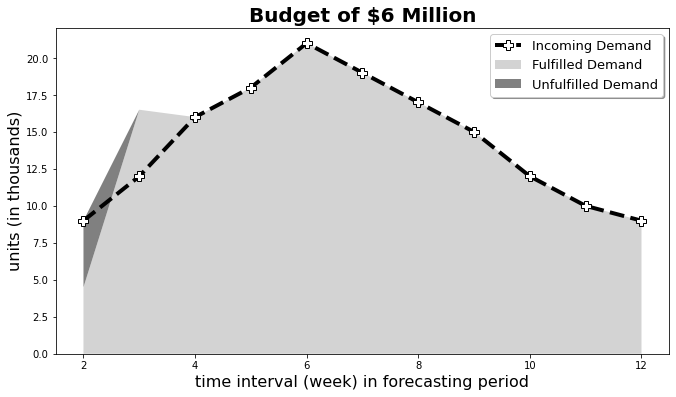

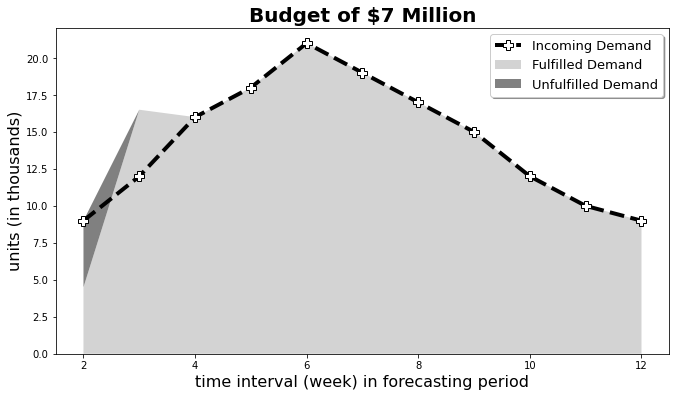

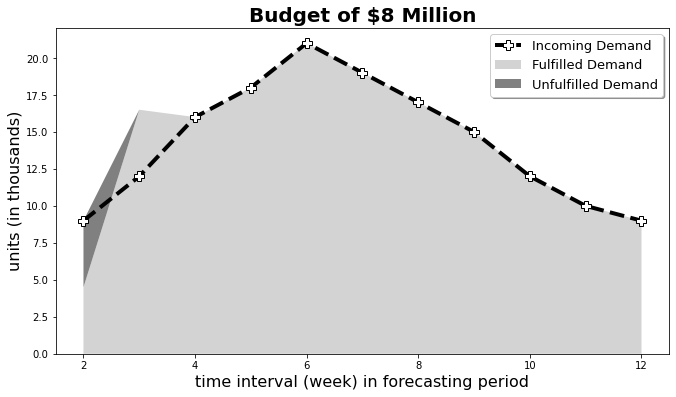

In [21]:
####impact of budget on suitability###
#reliability level 1
pal = ["#D3D3D3", "#808080"]

for b in budget_levels:
    fig_overtime, ax_overtime = plot.subplots(figsize=(11,6))

    #to get unfulfilled demand for each ordering period
    temp_budget_unfulfilled_demand =\
    unfulfilled_df_r1_k1[(unfulfilled_df_r1_k1['budget'] == b)&\
                         (unfulfilled_df_r1_k1['time_interval'] >1)]

    #to get fulfilled demand for each ordering period
    temp_budget_fulfilled_demand = \
    fulfilled_df_rely1_k1_summed_over_suppliers[
        (fulfilled_df_rely1_k1_summed_over_suppliers['budget'] == b)&\
                         (fulfilled_df_rely1_k1_summed_over_suppliers['time_interval'] >1)]
    
    temp_incoming_demand_df = \
    incoming_demand_df_r1_k1[incoming_demand_df_r1_k1['time_interval'] >1]

    # Your x and y axis
    x=range(2,T_set+1)
    y=[temp_budget_fulfilled_demand['units_thousands'],
       temp_budget_unfulfilled_demand['units_thousands']]
    ax_overtime.stackplot(x,y, 
                          labels=['Fulfilled Demand',
                                     'Unfulfilled Demand'], 
                             colors = pal)


    ax_overtime.plot(temp_incoming_demand_df['time_interval'], 
              temp_incoming_demand_df['units_thousands'], 
              label = 'Incoming Demand',
              marker = marker_style_lookup[k-1],
              linestyle = line_style_lookup[k-1],
             linewidth = 4,
             markersize = 10,
             c = color_lookup[k-1],
             markerfacecolor = marker_color_lookup[k-1])
    
    plot.xlabel('time interval (week) in forecasting period', fontsize = 16)
    plot.ylabel('units (in thousands)', fontsize = 16)
    plot.title('Budget of $'+ str(int(b/1000000)) +' Million', fontsize = 20, fontweight="bold")


    ax_overtime.legend(loc='upper right', shadow=True, fontsize=13)
    fig_overtime.savefig('healthcare_overtime_budget'+str(b/1000000)+'.png', dpi=300, bbox_inches='tight')

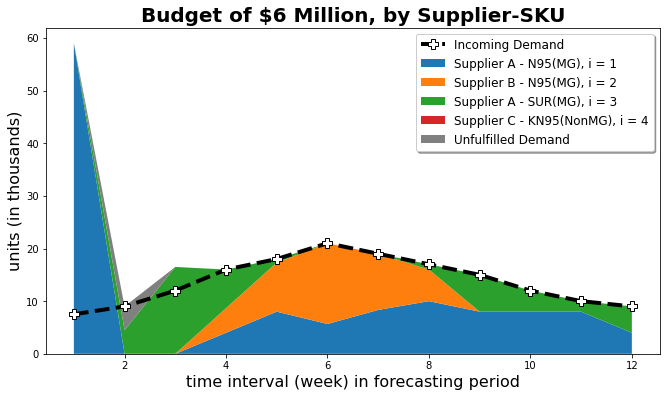

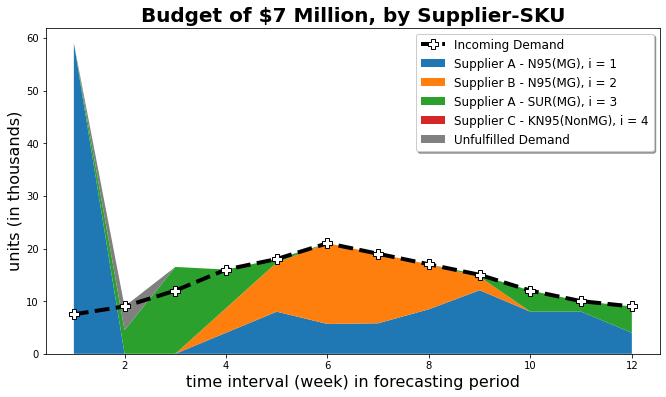

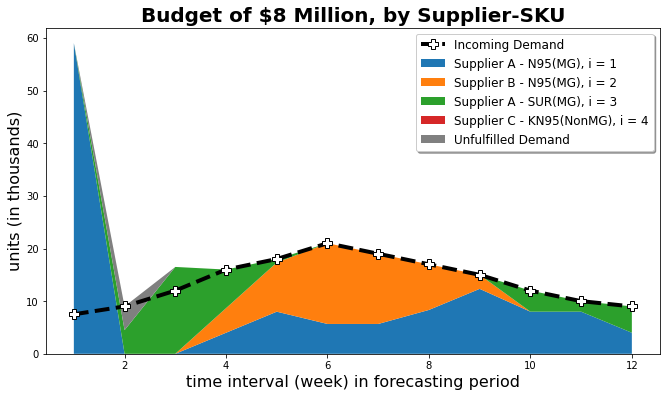

In [22]:
####impact of budget on suitability###
#reliability level 1
pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]
#the paper will only highlight health care overtime
k = 1

for b in budget_levels:
    fig_suitability, ax_suitability = plot.subplots(figsize=(11,6))

    #to get unfulfilled demand for each ordering period
    #by supplier-SKU
    temp_budget_fulfilled_demand = \
    fulfilled_df_rely1_k1[fulfilled_df_rely1_k1['budget']==b]

    #to get unfulfilled demand for each ordering period
    temp_budget_unfulfilled_demand =\
    unfulfilled_df_r1_k1[unfulfilled_df_r1_k1['budget'] == b]

    # Your x and y axis
    #note skip in example because 2 SKUs with N95s
    x=range(1,T_set+1)
    y=[temp_budget_fulfilled_demand
       [temp_budget_fulfilled_demand['group']==\
        names_SKU[0]]['units_thousands'],
       temp_budget_fulfilled_demand
       [temp_budget_fulfilled_demand['group']==\
        names_SKU[1]]['units_thousands'],
       temp_budget_fulfilled_demand
       [temp_budget_fulfilled_demand['group']==\
        names_SKU[2]]['units_thousands'],
       temp_budget_fulfilled_demand
       [temp_budget_fulfilled_demand['group']==\
        names_SKU[3]]['units_thousands'],
       temp_budget_unfulfilled_demand['units_thousands']]

    ax_suitability.stackplot(x,y, 
                             labels=[names_SKU[0],
                                     names_SKU[1],
                                     names_SKU[2], 
                                     names_SKU[3],
                                     'Unfulfilled Demand'], 
                             colors = pal)

    plot.plot(incoming_demand_df_r1_k1['time_interval'], 
              incoming_demand_df_r1_k1['units_thousands'], 
              label = 'Incoming Demand',
              marker = marker_style_lookup[k-1],
              linestyle = line_style_lookup[k-1],
             linewidth = 4,
             markersize = 10,
             c = color_lookup[k-1],
             markerfacecolor = marker_color_lookup[k-1])

    plot.xlabel('time interval (week) in forecasting period', fontsize = 16)
    plot.ylabel('units (in thousands)', fontsize = 16)
    plot.title('Budget of $'+ str(int(b/1000000)) +' Million, by Supplier-SKU', fontsize = 20, fontweight="bold")



    ax_suitability.legend(loc='upper right', shadow=True, fontsize=12)
    #fig_suitability.savefig('healthcare_overtime_budget_by_SKU'+str(b/1000000)+'.png', dpi=300, bbox_inches='tight')

In [ ]:
#### QUALITY IMPACTS #####

qual_df1 = fulfilled_df_plan[['reliability_level', 'budget',
                              'commodity_type', 'SKU', 'units_fulfilled']]\
.groupby(['reliability_level', 'budget', 'commodity_type', 'SKU']).sum().reset_index()

qual_df2 = qual_df1[['reliability_level', 'budget', 'commodity_type', 'units_fulfilled']]\
.groupby(['reliability_level', 'budget', 'commodity_type']).sum().reset_index()

qual_df3 = qual_df1.merge(qual_df2, 
           on = ['reliability_level', 
                 'budget', 'commodity_type'], how = 'left')

qual_df3['perc_of_total'] = \
(qual_df3['units_fulfilled_x']/qual_df3['units_fulfilled_y'])*100

#adjust budget to 1,000,000
qual_df3['budget'] = (qual_df3['budget']/1000000)


colors = ['red', 'blue', 'orange', 'purple']

###create figures SKUS ###
fig, axs = plot.subplots(2, 3, figsize=(12,8))

for rely in reliability_levels:
    for commodity in range(1,K_set+1):
        qual_df4 = qual_df3[(qual_df3['reliability_level'] == rely) & \
                            (qual_df3['commodity_type'] == commodity)]

        for SKU_temp in range(1,I_set+1):
            axs[rely-1, commodity-1].yaxis.set_major_formatter(mtick.PercentFormatter())
            axs[rely-1, commodity-1].set(ylim=(0, 105), xlim=(4.8,8.2))
            
            axs[rely-1, commodity-1].set(xlabel = 'budget (in millions)', \
                                 ylabel = 'percent of requests fulfilled by each SKU')
            
            qual_df5 = qual_df4[qual_df4['SKU'] == SKU_temp]
            
            if(int(SKU_temp) in I_k_dict.get(int(commodity))):
            
                axs[rely-1, commodity-1].plot('budget', 'perc_of_total',
                                              data = qual_df5,
                                              color = colors[SKU_temp-1],
                                              label = names_SKU[SKU_temp-1],
                                             marker = 'o')


                axs[rely-1, commodity-1].set_title(names_commodity_type[commodity-1]+' against\n'
                                                   + reliability_level_names[rely-1])
for ax in fig.get_axes():
    ax.label_outer()
    
lines, labels = fig.axes[-1].get_legend_handles_labels()
    
fig.legend(lines, labels, loc = 'upper center', ncol = I_set, title = 'SKU',
          bbox_to_anchor=(.5, 1.03), fontsize = 12, fancybox = True, title_fontsize=14)

In [ ]:
### ordering and recieving picture
pos_dict_all = {}
label_dict_all = {}
color_dict_all = {}
text_color_dict_all = {}
G_dict_all = {}
edge_labels_dict_all = {}

ordered_df_filtered = ordered_df_plan[(ordered_df_plan['reliability_level'] == 1) \
                                  & (ordered_df_plan['budget'] == budget_levels[selected_budget_level])]
recieved_df_filtered = recieved_df_plan[(recieved_df_plan['reliability_level'] == 1) \
                                  & (recieved_df_plan['budget'] == budget_levels[selected_budget_level])]


#lead times
f_i_l_dict = {tuple([1, 1]): .5,
                 tuple([1, 2]): .5,
                 tuple([2, 2]): (1/3),
                 tuple([2, 3]): (1/3),
                 tuple([2, 4]): (1/3),
                 tuple([3, 1]): .5,
                 tuple([3, 2]): .5,
                 tuple([4, 0]): 1}

#add zeros where there NA
for i in range(1, I_set+1):
    for l in range(T_set+1):
        if tuple([i,l]) not in f_i_l_dict:
            f_i_l_dict[tuple([i,l])] = 0

In [ ]:
f_i_l_dict

In [ ]:
for i in range(1, I_set+1):
    G = nx.DiGraph()
    label_dict = {}
    color_map = []
    text_color_map = []
    time_coordinates = range(1,T_set+1)
    ordered_amount_coordinates = np.array(ordered_df_filtered[(ordered_df_filtered['SKU'] == i)]['units_to_order'])
    recieved_amount_coordinates = np.array(recieved_df_filtered[(recieved_df_filtered['SKU'] == i)]['units_recieved'])

    for t in range(T_set):
        ordered_amount = ordered_amount_coordinates[t]
        recieved_amount = recieved_amount_coordinates[t]

        if (ordered_amount > 1):
            name = 'ordered at ' + str(t+1) + ' from Supplier-SKU ' + str(i)
            G.add_node(name, pos = (t+1,1))
            label_dict[name] = format(int(round(ordered_amount,0)), ',')
            #color_map.append('lightgray')
            #text_color_map.append('black')

        if (recieved_amount > 1):
            name = 'recieved at ' + str(t+1)+ ' from Supplier-SKU ' + str(i)
            G.add_node(name, pos = (t+1,2))
            label_dict[name] = format(int(round(recieved_amount,0)), ',')
            #color_map.append('white')
            #text_color_map.append('black')



        ordered_df_temp = ordered_df_filtered[(ordered_df_filtered['SKU'] == i) 
                                         & (ordered_df_filtered['units_to_order'] > 0)]

        for t_tilde in ordered_df_temp['time_interval']:
            for t in range(T_set+1):
                if t_tilde <= t:
                    frac = f_i_l_dict.get(tuple([i,t-t_tilde]))
                    if (frac > 0):
                        temp = ordered_df_temp[ordered_df_temp['time_interval'] == t_tilde]
                        edge_start = 'ordered at ' + str(t_tilde) + ' from Supplier-SKU ' + str(i)
                        edge_end = 'recieved at ' + str(t)+ ' from Supplier-SKU ' + str(i)
                        amount = format(round((frac*temp['units_to_order'].values[0]),0).astype(int), ',')
                        G.add_edge(edge_start, edge_end, label=amount)

    edge_labels_dict_all['Supplier-SKU' + str(i)]  = nx.get_edge_attributes(G, 'label')
    pos=nx.get_node_attributes(G,'pos')
    label_dict_all['Supplier-SKU' + str(i)] = label_dict
    #text_color_dict_all['Supplier-SKU' + str(i)] = text_color_map
    pos_dict_all['Supplier-SKU' + str(i)] = pos
    G_dict_all['Supplier-SKU' + str(i)] = G


    for key in pos_dict_all['Supplier-SKU' + str(i)].keys():
        if 'ordered' in key:
            color_map.append('lightgray')
        else:
            color_map.append('white')

    color_dict_all['Supplier-SKU' + str(i)]=color_map

In [ ]:
for i in range(1, I_set+1):
    fig_ordering_recieving, ax_ordering_recieving = plot.subplots(figsize=(11,6))


    nx.draw(G_dict_all.get('Supplier-SKU' + str(i)),
            pos = pos_dict_all.get('Supplier-SKU' + str(i)), 
            labels=label_dict_all.get('Supplier-SKU' + str(i)),
            node_size=2000, 
            font_size=13,
            edgecolors= 'black', 
            font_color = 'black',
            with_labels = True, 
            node_color=color_dict_all.get('Supplier-SKU' + str(i)), 
            ax = ax_ordering_recieving)#,
            #font_weight = 'bold')

    label_pos_temp = .7

    #nx.set_edgecolor('r')

    for k in edge_labels_dict_all.get('Supplier-SKU' + str(i)).keys():
        temp1 = edge_labels_dict_all.get('Supplier-SKU' + str(i)).get(k)
        temp2 = {k:temp1}

        if(label_pos_temp == .7):
            label_pos_temp = .3
        else:
            label_pos_temp = .7

        nx.draw_networkx_edge_labels(G_dict_all.get('Supplier-SKU' + str(i)), 
                                     pos_dict_all.get('Supplier-SKU' + str(i)), 
                                     temp2,
                                     label_pos = label_pos_temp,
                                    #arrows = True,
                                    font_size = 11)

        #nx.draw_networkx_edge_labels(G_dict_all.get('supplier' + str(i)), pos_dict_all.get('supplier' + str(i)), 
        #                             edge_labels_dict_all.get('supplier' + str(i)),
        #                            label_pos = pos_dict_all_labels)


    ax_ordering_recieving.set_xlabel('Week in forecasting period\n'+r'$t\in\mathcal{T}$',
                 fontsize = 15)
    ax_ordering_recieving.set_ylabel('Place order              Recieve order',
                 fontsize = 15)
    ax_ordering_recieving.set(ylim=(.5, 2.5))
    ax_ordering_recieving.xaxis.set_ticks(np.arange(1, T_set+1, 1))
    ax_ordering_recieving.set_title('Time Interval Order is Placed and Recieved \n from '+ names_SKU[i-1],
                fontsize = 20)
    #ax.set_title('Ordering schedule for ' + names_supplier_SKU[i-1],# + ' with reliability level '+ "{:.0%}".format(reliability_level),
    #            fontsize='x-large')
    ax_ordering_recieving.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
    limits=plot.axis('on')

    if i == 1:
        plot.savefig('ordering_recieving_SS1.jpg')
    if i == 2:
        plot.savefig('ordering_recieving_SS2.jpg')
    if i == 3:
        plot.savefig('ordering_recieving_SS3.jpg')
    if i == 4:
        plot.savefig('ordering_recieving_SS4.jpg')

In [ ]:
####calculate incoming orders after week of expected event ###
ordered_df_expected_event = ordered_df_filtered[ordered_df_filtered['time_interval']<=past_before_unexpected_event]
o_i_t = {}

for i in range(1,I_set+1):
    incoming_orders_temp = np.zeros(T_set)
    ordered_df_week_by_i = ordered_df_expected_event[ordered_df_expected_event['SKU']==i]
    for t_tilde in set(ordered_df_week_by_i['time_interval']):
        ordered_df_week_by_i_t = ordered_df_week_by_i[ordered_df_week_by_i['time_interval']==t_tilde]
        units_ordered = ordered_df_week_by_i_t['units_to_order']
        #print(ordered_df_week_by_i_t)
        for t in range(T_set+1):
            if t_tilde <= t: 
                frac = f_i_l_dict.get(tuple([i,t-t_tilde]))
                incoming_orders_temp[t-1] = incoming_orders_temp[t-1]+(frac*units_ordered)
    o_i_t[i] = incoming_orders_temp

In [ ]:
o_i_t[4]